In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
''' train and test path '''
train_path = '../input/brain-tumor-classification-mri/Training'
test_path = '../input/brain-tumor-classification-mri/Testing'

In [3]:
File=[]
for f in os.listdir(train_path):
    File += [f]

'''  total number of classes '''
print(File)

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']


In [12]:
''' reading images '''

train_data = []

''' label encoding '''
mapping={'no_tumor':0, 'pituitary_tumor':1, 'meningioma_tumor':2, 'glioma_tumor':3}

count=0

for f in os.listdir(train_path):
    ''' joining path '''
    path = os.path.join(train_path, f)
    for im in os.listdir(path):
        ''' loading an image '''
        img = load_img(os.path.join(path, im), grayscale=False, color_mode='rgb', target_size=(150,150))
        ''' converting an image to array '''
        img = img_to_array(img)
        ''' scaling  '''
        img = img / 255.0
        ''' appending image to train_data '''
        train_data.append([img, count])     
    count=count+1

In [13]:
test_data = []

''' label encoding '''
mapping={'no_tumor':0, 'pituitary_tumor':1, 'meningioma_tumor':2, 'glioma_tumor':3}
count=0

for f in os.listdir(test_path):
    ''' joining path '''
    path=os.path.join(test_path, f)
    for im in os.listdir(path):
        ''' loading an image '''
        img = load_img(os.path.join(path, im), grayscale=False, color_mode='rgb', target_size=(150,150))
        ''' converting an image to array '''
        img = img_to_array(img)
        ''' scaling '''
        img = img/255.0
        ''' appending an image to test_data'''
        test_data.append([img, count])         
    count=count+1

In [14]:
train_images, train_labels = zip(*train_data)
test_images, test_labels = zip(*test_data)

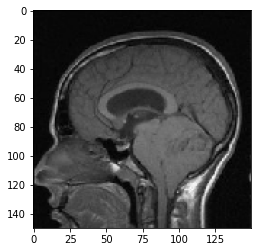

In [15]:
plt.imshow(train_images[0],cmap='turbo')
plt.show()

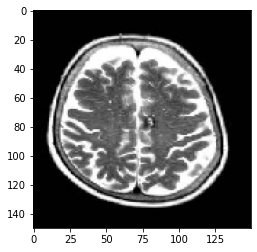

In [16]:
plt.imshow(train_images[2])
plt.show()

In [17]:
''' converting labels into to_categorical '''
train_labels = to_categorical(train_labels)

''' coverting train_images into numpy array '''
train_images = np.array(train_images)

''' converting train_labesl into numpy array '''
train_labels = np.array(train_labels)

''' shaep of train_images and train_labels '''
print(train_images.shape)
print(train_labels.shape)

(2870, 150, 150, 3)
(2870, 4)


In [18]:
''' converting labels into to_categorical '''
test_labels = to_categorical(test_labels)

''' coverting test_images into numpy array '''
test_images = np.array(test_images)

''' converting train_labesl into numpy array '''
test_labels = np.array(test_labels)

''' shaep of test_images and test_labels '''
print(test_images.shape)
print(test_labels.shape)

(394, 150, 150, 3)
(394, 4)


In [19]:
''' reshaping images '''
train_images = train_images.reshape(-1,150,150,3)
test_images = test_images.reshape(-1,150,150,3)

In [20]:
''' train test split '''
X_train, X_test, y_train, y_test = train_test_split(train_images,train_labels, test_size=0.2,random_state=44)

In [21]:
''' shape of X_train, X_test, y_train, y_test '''
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2296, 150, 150, 3)
(574, 150, 150, 3)
(2296, 4)
(574, 4)


In [22]:
''' data Augmentation '''
data_aug = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, zoom_range=0.2,
                    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.1, fill_mode="nearest")

In [23]:
''' DenseNet201 Model '''
model1 = tf.keras.applications.DenseNet201(input_shape=(150,150,3),include_top=False,weights='imagenet',pooling='avg')

''' freezing layers '''
model1.trainable = False

2022-11-04 08:19:48.228864: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 08:19:48.237132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 08:19:48.237875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 08:19:48.238928: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [24]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
inp = model1.input
''' Hidden Layer '''
x = tf.keras.layers.Dense(128, activation='relu')(model1.output)
''' Classification Layer '''
out = tf.keras.layers.Dense(4, activation='softmax')(x)

''' Model '''
model = tf.keras.Model(inputs=inp, outputs=out)

''' compile the model '''
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
''' training '''
history = model.fit(data_aug.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=100, callbacks = [callback])

2022-11-04 08:19:53.695824: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-04 08:20:03.389029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


72/72 [==============================] - 29s 253ms/step - loss: 0.9060 - accuracy: 0.6407 - val_loss: 0.6706 - val_accuracy: 0.7578
Epoch 2/100
72/72 [==============================] - 13s 180ms/step - loss: 0.5293 - accuracy: 0.7888 - val_loss: 0.7343 - val_accuracy: 0.7422
Epoch 3/100
72/72 [==============================] - 13s 180ms/step - loss: 0.4777 - accuracy: 0.8158 - val_loss: 0.5541 - val_accuracy: 0.7979
Epoch 4/100
72/72 [==============================] - 13s 185ms/step - loss: 0.4420 - accuracy: 0.8393 - val_loss: 0.5331 - val_accuracy: 0.8188
Epoch 5/100
72/72 [==============================] - 13s 180ms/step - loss: 0.4023 - accuracy: 0.8458 - val_loss: 0.6884 - val_accuracy: 0.7700
Epoch 6/100
72/72 [==============================] - 14s 188ms/step - loss: 0.3934 - accuracy: 0.8454 - val_loss: 0.5249 - val_accuracy: 0.8171


model = tf.keras.models.load_model('model_1_densenet.h5')
model.load_weights('mine_model_weights.h5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
''' prediction '''
y_pred=model.predict(X_test)

''' retreiving max val from predicted values '''
pred = np.argmax(y_pred,axis=1)

''' retreiving max val from actual values '''
ground = np.argmax(y_test,axis=1)

''' classificaion report '''
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.89      0.83      0.86        81
           1       0.69      0.99      0.81       157
           2       0.89      0.67      0.77       170
           3       0.92      0.80      0.86       166

    accuracy                           0.82       574
   macro avg       0.85      0.82      0.82       574
weighted avg       0.84      0.82      0.82       574



In [27]:
!pip install keras-tuner

In [28]:
from tensorflow import keras
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Conv2D(hp.Int('input_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3), input_shape=X_train.shape[1:]))

    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    for i in range(hp.Int('nlayers', 1, 4)):  # adding variation of layers.
        model.add(Conv2D(hp.Int(f'conv{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten()) 
    model.add(Dense(4))
    model.add(Activation("softmax"))

    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [29]:
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [44]:
tuner_search=RandomSearch(build_model,objective='val_loss',
                          max_trials=5,directory='output',project_name="Mnist Fashion")

In [45]:
tuner_search.search(X_train,y_train,epochs=10,validation_data=(X_test, y_test),callbacks = [callback])

In [46]:
model=tuner_search.get_best_models(num_models=1)[0]

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 96)        1

In [48]:
model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), initial_epoch=10,callbacks = [callback])

2022-11-04 08:23:41.146676: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 619920000 exceeds 10% of free system memory.
2022-11-04 08:23:41.846762: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 619920000 exceeds 10% of free system memory.


Epoch 11/100
72/72 [==============================] - 4s 40ms/step - loss: 0.3306 - accuracy: 0.8702 - val_loss: 0.4800 - val_accuracy: 0.8101
Epoch 12/100
72/72 [==============================] - 2s 25ms/step - loss: 0.2156 - accuracy: 0.9172 - val_loss: 0.4313 - val_accuracy: 0.8780
Epoch 13/100
72/72 [==============================] - 2s 26ms/step - loss: 0.1366 - accuracy: 0.9495 - val_loss: 0.4546 - val_accuracy: 0.8763
Epoch 14/100
72/72 [==============================] - 2s 25ms/step - loss: 0.0851 - accuracy: 0.9730 - val_loss: 0.4991 - val_accuracy: 0.8990


In [49]:
y_pred=model.predict(X_test)

''' retreiving max val from predicted values '''
pred = np.argmax(y_pred,axis=1)

''' retreiving max val from actual values '''
ground = np.argmax(y_test,axis=1)

''' classificaion report '''
print(classification_report(ground,pred))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81        81
           1       0.97      0.97      0.97       157
           2       0.83      0.91      0.87       170
           3       0.91      0.89      0.90       166

    accuracy                           0.90       574
   macro avg       0.90      0.88      0.89       574
weighted avg       0.90      0.90      0.90       574



pituitary_tumor


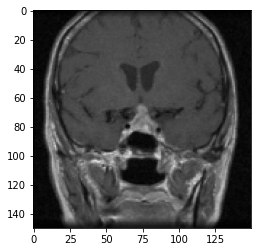

In [50]:
import os, random
path = "../input/brain-tumor-classification-mri/Testing/"
randomtest = random.choice(os.listdir("../input/brain-tumor-classification-mri/Testing/"))
randomimage = random.choice(os.listdir(("../input/brain-tumor-classification-mri/Testing/")+str(randomtest)+'/'))
print(randomtest)
randomimage = load_img((path+randomtest+'/'+randomimage),target_size=(150,150))
plt.imshow(randomimage)
''' converting img to array '''
randomimage = img_to_array(randomimage) 

''' scaling '''
img = randomimage/255.0

''' expanding dimensions '''
img = np.expand_dims(img, axis=0)

In [51]:
lbl_encoding = {0:'no_tumor', 1:'pituitary_tumor', 2:'meningioma_tumor', 3:'glioma_tumor'}

def map_label(val):
    return lbl_encoding[val]

''' predicion '''
pred = model.predict(img)

''' retreiving max val from predited values'''
val = np.argmax(pred)
map_val  = map_label(val)

print("Prediction is {}.".format(map_val))

Prediction is pituitary_tumor.
